In [ ]:
import zipfile
import tarfile
import gzip
import os
from PIL import Image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import time
import random

In [ ]:
# Extract the zip file
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Files extracted to: {extract_to}")

In [ ]:
extract_zip(zip_path=r'/content/lfwa.zip', extract_to=r'/content/lfwa')

Files extracted to: /content/lfwa


## Data analysis

In [ ]:
# Function to parse the pairs file
def parse_pairs_file(file_path, root_dir):
    pairs = []
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]  # Skip the header line
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:   # Same person: [name, img1, img2]
                name, img1, img2 = parts
                img1_path = os.path.join(root_dir, name, f"{name}_{int(img1):04d}.jpg")
                img2_path = os.path.join(root_dir, name, f"{name}_{int(img2):04d}.jpg")
                pairs.append((img1_path, img2_path, 1))  # Label 1 for "same"
            elif len(parts) == 4:   # Different people: [name1, img1, name2, img2]
                name1, img1, name2, img2 = parts
                img1_path = os.path.join(root_dir, name1, f"{name1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(root_dir, name2, f"{name2}_{int(img2):04d}.jpg")
                pairs.append((img1_path, img2_path, 0))  # Label 0 for "different"
    return pairs

In [ ]:
# Define root directory for images
image_root_dir = '/content/lfwa/lfw2/lfw2'


# Parse train and test files
test_pairs = parse_pairs_file('/content/pairsDevTest.txt', image_root_dir)
train_pairs = parse_pairs_file('/content/pairsDevTrain.txt', image_root_dir)


# Check results
print("Train pairs:", train_pairs[:5])
print("Test pairs:", test_pairs[:5])


# Verify the paths in train_pairs
for img1_path, img2_path, _ in train_pairs[:5]:
    print(f"Checking: {img1_path} - Exists: {os.path.exists(img1_path)}")
    print(f"Checking: {img2_path} - Exists: {os.path.exists(img2_path)}")


Train pairs: [('/content/lfwa/lfw2/lfw2/Aaron_Peirsol/Aaron_Peirsol_0001.jpg', '/content/lfwa/lfw2/lfw2/Aaron_Peirsol/Aaron_Peirsol_0002.jpg', 1), ('/content/lfwa/lfw2/lfw2/Aaron_Peirsol/Aaron_Peirsol_0003.jpg', '/content/lfwa/lfw2/lfw2/Aaron_Peirsol/Aaron_Peirsol_0004.jpg', 1), ('/content/lfwa/lfw2/lfw2/Aaron_Sorkin/Aaron_Sorkin_0001.jpg', '/content/lfwa/lfw2/lfw2/Aaron_Sorkin/Aaron_Sorkin_0002.jpg', 1), ('/content/lfwa/lfw2/lfw2/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg', '/content/lfwa/lfw2/lfw2/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0002.jpg', 1), ('/content/lfwa/lfw2/lfw2/Abdullah/Abdullah_0001.jpg', '/content/lfwa/lfw2/lfw2/Abdullah/Abdullah_0003.jpg', 1)]
Test pairs: [('/content/lfwa/lfw2/lfw2/Abdullah_Gul/Abdullah_Gul_0013.jpg', '/content/lfwa/lfw2/lfw2/Abdullah_Gul/Abdullah_Gul_0014.jpg', 1), ('/content/lfwa/lfw2/lfw2/Abdullah_Gul/Abdullah_Gul_0013.jpg', '/content/lfwa/lfw2/lfw2/Abdullah_Gul/Abdullah_Gul_0016.jpg', 1), ('/content/lfwa/lfw2/lfw2/Abdullatif_Sener/Abdulla

In [ ]:
# Function to read and preprocess an image in PyTorch
def read_image(path_of_image):
    try:
        # Open image
        image = Image.open(path_of_image).convert('L')  # Convert to grayscale ('L')

        # Define preprocessing pipeline
        transform = transforms.Compose([
            transforms.Resize((105, 105)),  # Resize to 105x105                                    # need to check bc in the original paper it is 105*105 but here the dataset is 250*250. maybe need to keep it that way.
            transforms.ToTensor(),         # Convert to tensor and normalize to [0, 1]
        ])

        # Apply preprocessing
        image = transform(image)
        return image
    except FileNotFoundError:
        print(f"Image not found: {path_of_image}")
        return None

In [ ]:
# Print the number of pairs in each set
print(f"Number of train pairs: {len(train_pairs)}")
#print(f"Number of validation pairs: {len(val_pairs)}")
print(f"Number of test pairs: {len(test_pairs)}")


Number of train pairs: 2200
Number of test pairs: 1000


In [ ]:
# Function to count labels
def count_labels(pairs):
    same = sum(1 for _, _, label in pairs if label == 1)
    different = len(pairs) - same
    return same, different

In [ ]:
# Count labels for training and test sets
train_same, train_diff = count_labels(train_pairs)
test_same, test_diff = count_labels(test_pairs)

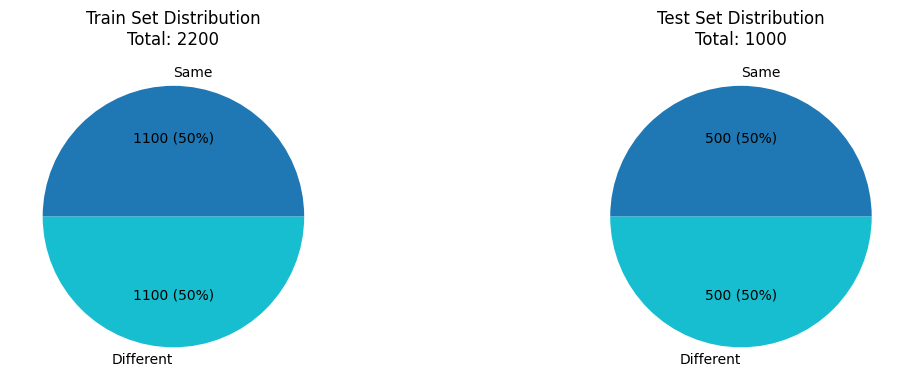

In [ ]:
# Pie chart for label distribution in each set with counts
def plot_pie_chart_with_counts(train_counts, test_counts):
    labels = ['Same', 'Different']
    train_same, train_diff = train_counts
    test_same, test_diff = test_counts

    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    # Function to add counts and percentages
    def add_counts_and_percentage(ax, counts, labels):
        total = sum(counts)
        ax.pie(counts, labels=labels, autopct=lambda p: f"{int(p * total / 100)} ({int(p)}%)", colors=['tab:blue', 'tab:cyan'])

    # Pie chart for train set
    ax[0].set_title(f'Train Set Distribution\nTotal: {sum(train_counts)}')
    add_counts_and_percentage(ax[0], [train_same, train_diff], labels)

    # Pie chart for validation set
    ax[1].set_title(f'Test Set Distribution\nTotal: {sum(test_counts)}')
    add_counts_and_percentage(ax[1], [test_same, test_diff], labels)

    plt.tight_layout()
    plt.show()

# Call function to plot pie charts with counts
plot_pie_chart_with_counts([train_same, train_diff], [test_same, test_diff])

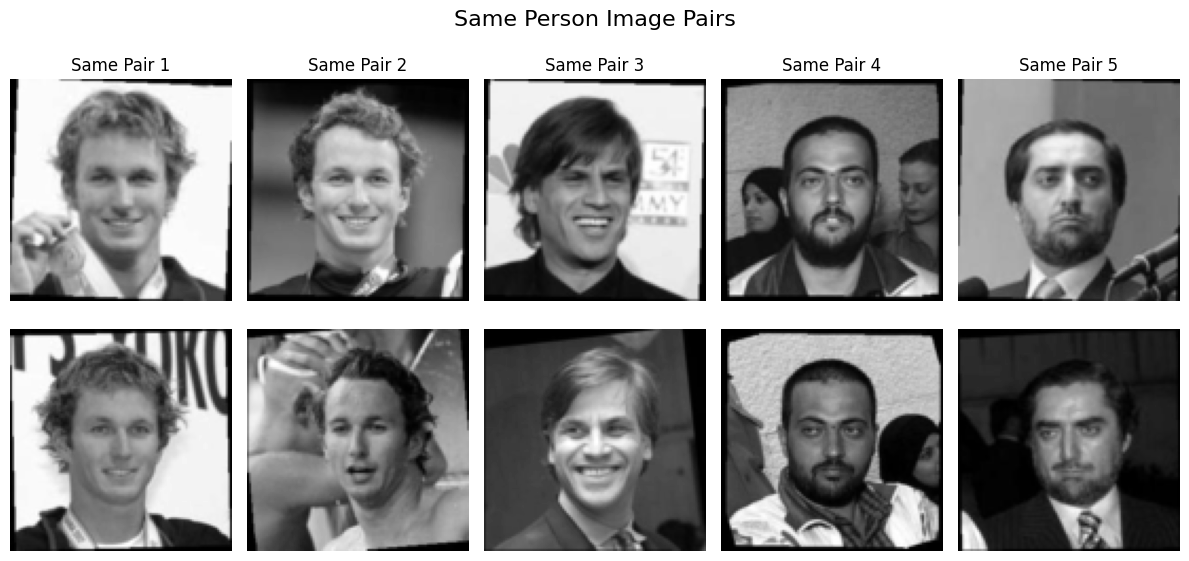

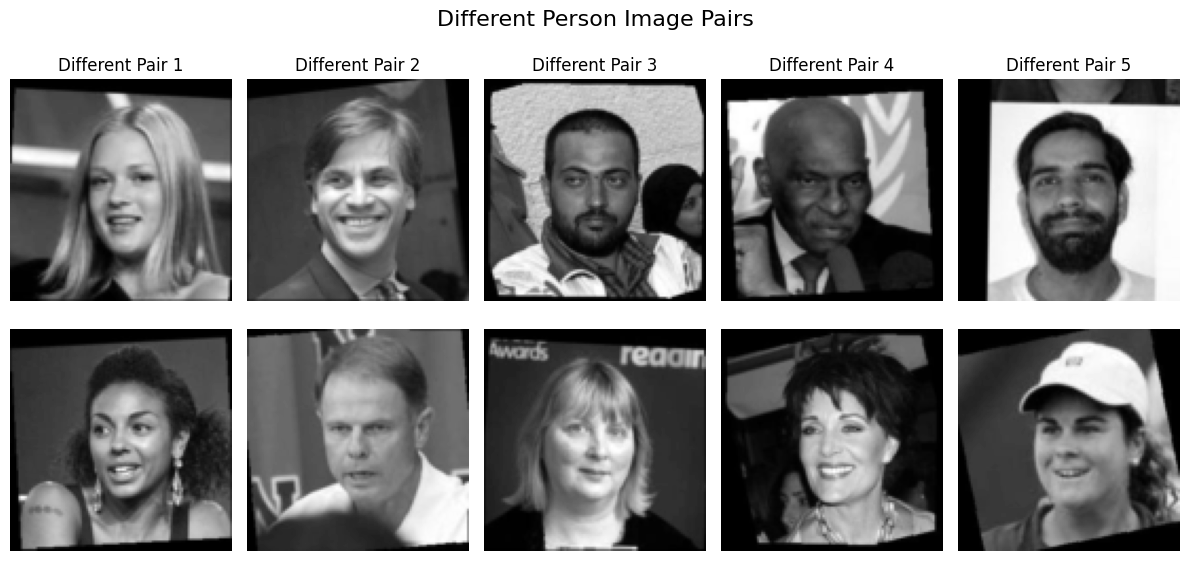

In [ ]:
# Function to visualize same and different pairs
def visualize_same_diff_pairs(pairs, num_samples=5):
    same_pairs = [pair for pair in pairs if pair[2] == 1]  # Same person pairs
    diff_pairs = [pair for pair in pairs if pair[2] == 0]  # Different person pairs

    # Select samples
    same_samples = same_pairs[:num_samples]
    diff_samples = diff_pairs[:num_samples]

    # Create subplots
    plt.figure(figsize=(12, 6))

    # Display same pairs
    for i, (img1_path, img2_path, label) in enumerate(same_samples):
        img1 = read_image(img1_path)
        img2 = read_image(img2_path)
        if img1 is not None and img2 is not None:
            img1 = img1.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
            img2 = img2.permute(1, 2, 0).numpy()
            plt.subplot(2, num_samples, i+1)
            plt.imshow(img1.squeeze(), cmap='gray')
            plt.axis('off')
            plt.title(f"Same Pair {i+1}")
            plt.subplot(2, num_samples, i+num_samples+1)
            plt.imshow(img2.squeeze(), cmap='gray')
            plt.axis('off')
            # plt.title(f"Same Pair {i+1}")

    plt.suptitle("Same Person Image Pairs", fontsize=16)
    plt.tight_layout()
    plt.show()

    # Create subplots for different pairs
    plt.figure(figsize=(12, 6))
    for i, (img1_path, img2_path, label) in enumerate(diff_samples):
        img1 = read_image(img1_path)
        img2 = read_image(img2_path)
        if img1 is not None and img2 is not None:
            img1 = img1.permute(1, 2, 0).numpy()
            img2 = img2.permute(1, 2, 0).numpy()
            plt.subplot(2, num_samples, i+1)
            plt.imshow(img1.squeeze(), cmap='gray')
            plt.axis('off')
            plt.title(f"Different Pair {i+1}")
            plt.subplot(2, num_samples, i+num_samples+1)
            plt.imshow(img2.squeeze(), cmap='gray')
            plt.axis('off')
            # plt.title(f"Different Pair {i+1}")

    plt.suptitle("Different Person Image Pairs", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize samples from the train/test set
visualize_same_diff_pairs(train_pairs + test_pairs, num_samples=5)


In [ ]:
train_pairs, val_pairs = train_test_split(train_pairs, test_size=0.15, random_state=42)

In [ ]:
# Print the number of pairs in each set
print(f"Number of train pairs: {len(train_pairs)}")
print(f"Number of validation pairs: {len(val_pairs)}")
print(f"Number of test pairs: {len(test_pairs)}")


Number of train pairs: 1870
Number of validation pairs: 330
Number of test pairs: 1000


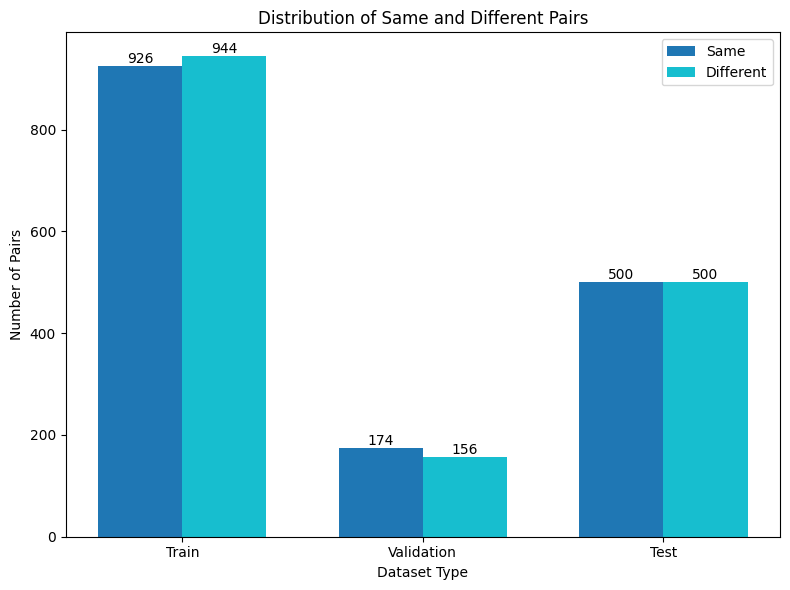

In [ ]:
# Count labels for training, validation, and test sets
train_same, train_diff = count_labels(train_pairs)
val_same, val_diff = count_labels(val_pairs)
test_same, test_diff = count_labels(test_pairs)

# Plot combined graph for train, validation, and test
labels_all = ['Train', 'Validation', 'Test']
same_counts = [train_same, val_same, test_same]
diff_counts = [train_diff, val_diff, test_diff]

# Plot combined
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
index = np.arange(len(labels_all))

# Plot both bars
bars_same = ax.bar(index, same_counts, bar_width, label='Same', color='tab:blue')
bars_diff = ax.bar(index + bar_width, diff_counts, bar_width, label='Different', color='tab:cyan')

# Add text on bars for Same
for bar in bars_same:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

# Add text on bars for Different
for bar in bars_diff:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

ax.set_xlabel('Dataset Type')
ax.set_ylabel('Number of Pairs')
ax.set_title('Distribution of Same and Different Pairs')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels_all)
ax.legend()

plt.tight_layout()
plt.show()

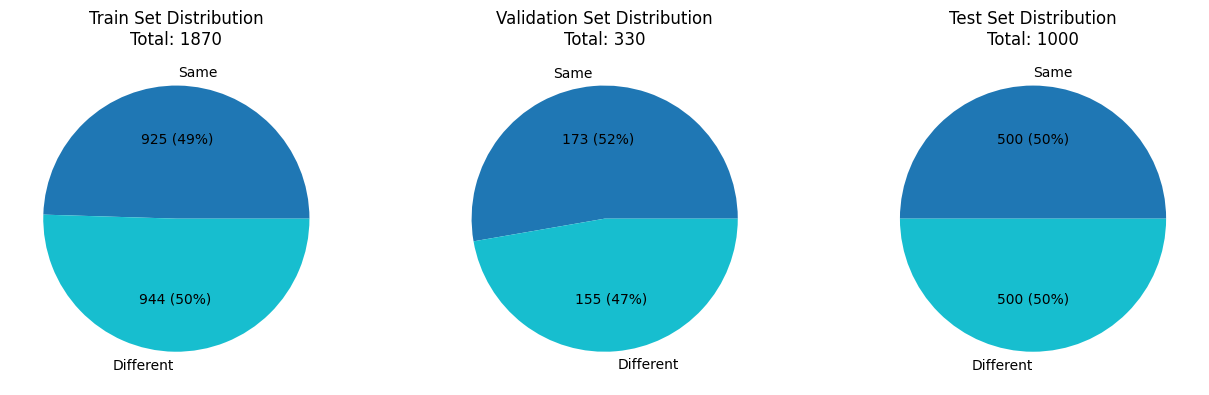

In [ ]:
# Pie chart for label distribution in each set with counts
def plot_pie_chart_with_counts(train_counts, val_counts, test_counts):
    labels = ['Same', 'Different']
    train_same, train_diff = train_counts
    val_same, val_diff = val_counts
    test_same, test_diff = test_counts

    fig, ax = plt.subplots(1, 3, figsize=(13, 4))

    # Function to add counts and percentages
    def add_counts_and_percentage(ax, counts, labels):
        total = sum(counts)
        ax.pie(counts, labels=labels, autopct=lambda p: f"{int(p * total / 100)} ({int(p)}%)", colors=['tab:blue', 'tab:cyan'])

    # Pie chart for train set
    ax[0].set_title(f'Train Set Distribution\nTotal: {sum(train_counts)}')
    add_counts_and_percentage(ax[0], [train_same, train_diff], labels)

    # Pie chart for validation set
    ax[1].set_title(f'Validation Set Distribution\nTotal: {sum(val_counts)}')
    add_counts_and_percentage(ax[1], [val_same, val_diff], labels)

    # Pie chart for test set
    ax[2].set_title(f'Test Set Distribution\nTotal: {sum(test_counts)}')
    add_counts_and_percentage(ax[2], [test_same, test_diff], labels)

    plt.tight_layout()
    plt.show()

# Call function to plot pie charts with counts
plot_pie_chart_with_counts([train_same, train_diff], [val_same, val_diff], [test_same, test_diff])

## Siamse network

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, pairs, transform=None):
        """
        Args:
            pairs (list of tuples): List of (img1_path, img2_path, label).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pairs = pairs
        self.transform = transform


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]


        img1 = self._read_image(img1_path)
        img2 = self._read_image(img2_path)

        return (img1, img2), torch.tensor(label, dtype=torch.float32)

    def _read_image(self, path):
        # Load images
        img = Image.open(path).convert("L")
        # Apply transformations if any
        if self.transform:
          return self.transform(img)
        return img

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn_feature_extractor = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.07),
            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.07),
            nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.07),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),  # Adjust based on input size instead of 6*6 we change to 24*24 to fit into 250*250 image size
            nn.Sigmoid()
        )

        self.fc = nn.Linear(4096, 1)

    def forward(self, img1, img2):
        feat1 = self.cnn_feature_extractor(img1)
        feat2 = self.cnn_feature_extractor(img2)
        l1_distance = torch.abs(feat1 - feat2)
        output = torch.sigmoid(self.fc(l1_distance))
        return output


    def initialize_weights(module):
        if isinstance(module, nn.Conv2d):
            nn.init.normal_(module.weight, mean=0.0, std=0.01)
            nn.init.normal_(module.bias, mean=0.5, std=0.01)
        elif isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.2)
            nn.init.normal_(module.bias, mean=0.5, std=0.01)

    def train_model(self, train_loader, val_loader, epochs=10, learning_rate=0.001, optimizer_cls=torch.optim.Adam, momentum=0):
        # Initialize optimizer
        if optimizer_cls == torch.optim.SGD:
            optimizer = optimizer_cls(self.parameters(), lr=learning_rate, momentum=momentum)
        else:
            optimizer = optimizer_cls(self.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()
        best_val_loss = float('inf')

        # Tracking metrics
        history = {
            'train_loss': [], 'val_loss': [],
            'train_accuracy': [], 'val_accuracy': [],
            'train_auc': [], 'val_auc': []
        }

        for epoch in range(epochs):
            self.train()
            train_loss, train_preds, train_labels = 0, [], []
            for (img1, img2), labels in train_loader:
                img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
                optimizer.zero_grad()
                outputs = self(img1, img2).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Record metrics
                train_loss += loss.item()
                train_preds.extend(outputs.detach().cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

            # Calculate training metrics
            train_loss /= len(train_loader)
            train_accuracy = ((np.array(train_preds) > 0.5) == np.array(train_labels)).mean()
            train_auc = roc_auc_score(train_labels, train_preds)

            # Validation step
            self.eval()
            val_loss, val_preds, val_labels = 0, [], []
            with torch.no_grad():
                for (img1, img2), labels in val_loader:
                    img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
                    outputs = self(img1, img2).squeeze()
                    val_loss += criterion(outputs, labels).item()
                    val_preds.extend(outputs.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

            # Calculate validation metrics
            val_loss /= len(val_loader)
            val_accuracy = ((np.array(val_preds) > 0.5) == np.array(val_labels)).mean()
            val_auc = roc_auc_score(val_labels, val_preds)

            # Store metrics
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_accuracy'].append(train_accuracy)
            history['val_accuracy'].append(val_accuracy)
            history['train_auc'].append(train_auc)
            history['val_auc'].append(val_auc)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 5:  # Hardcoded patience of 5 epochs
                    print("Early stopping triggered.")
                    break

            print(f"Epoch {epoch + 1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f} | "
                  f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        return history

    def evaluate(self, test_loader):
        self.eval()
        test_loss, test_preds, test_labels = 0, [], []
        criterion = nn.BCELoss()

        with torch.no_grad():
            for (img1, img2), labels in test_loader:
                img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
                outputs = self(img1, img2).squeeze()
                test_loss += criterion(outputs, labels).item()
                test_preds.extend(outputs.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        test_accuracy = ((np.array(test_preds) > 0.5) == np.array(test_labels)).mean()
        test_auc = roc_auc_score(test_labels, test_preds)

        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | Test AUC: {test_auc:.4f}\n")
        return test_loss, test_accuracy, test_auc

In [ ]:
# Function to plot metrics
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Loss Plot
    axes[0].plot(epochs, history['train_loss'], label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid()

    # Accuracy Plot
    axes[1].plot(epochs, history['train_accuracy'], label='Train Accuracy')
    axes[1].plot(epochs, history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid()

    # AUC Plot
    axes[2].plot(epochs, history['train_auc'], label='Train AUC')
    axes[2].plot(epochs, history['val_auc'], label='Val AUC')
    axes[2].set_title('AUC')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid()

    plt.tight_layout()

## Hyperparameter Search and Training Loop




Training with parameters: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 1/10 | Train Loss: 0.6566 | Val Loss: 0.6307 | Train Acc: 0.5925 | Val Acc: 0.6576 | Train AUC: 0.6558 | Val AUC: 0.7246
Epoch 2/10 | Train Loss: 0.5473 | Val Loss: 0.6031 | Train Acc: 0.7422 | Val Acc: 0.6667 | Train AUC: 0.8186 | Val AUC: 0.7444
Epoch 3/10 | Train Loss: 0.4526 | Val Loss: 0.5828 | Train Acc: 0.8203 | Val Acc: 0.6727 | Train AUC: 0.9060 | Val AUC: 0.7458
Epoch 4/10 | Train Loss: 0.3514 | Val Loss: 0.5636 | Train Acc: 0.8840 | Val Acc: 0.6848 | Train AUC: 0.9611 | Val AUC: 0.7381
Epoch 5/10 | Train Loss: 0.2692 | Val Loss: 0.5658 | Train Acc: 0.9337 | Val Acc: 0.6879 | Train AUC: 0.9858 | Val AUC: 0.7568
Epoch 6/10 | Train Loss: 0.1877 | Val Loss: 0.5660 | Train Acc: 0.9759 | Val Acc: 0.6848 | Train AUC: 0.9965 | Val AUC: 0.7611
Epoch 7/10 | Train Loss: 0.1188 | Val Loss: 0.5645 | Train Acc: 0.9947 | Val Acc: 0.7091 | Train AUC: 0.9998

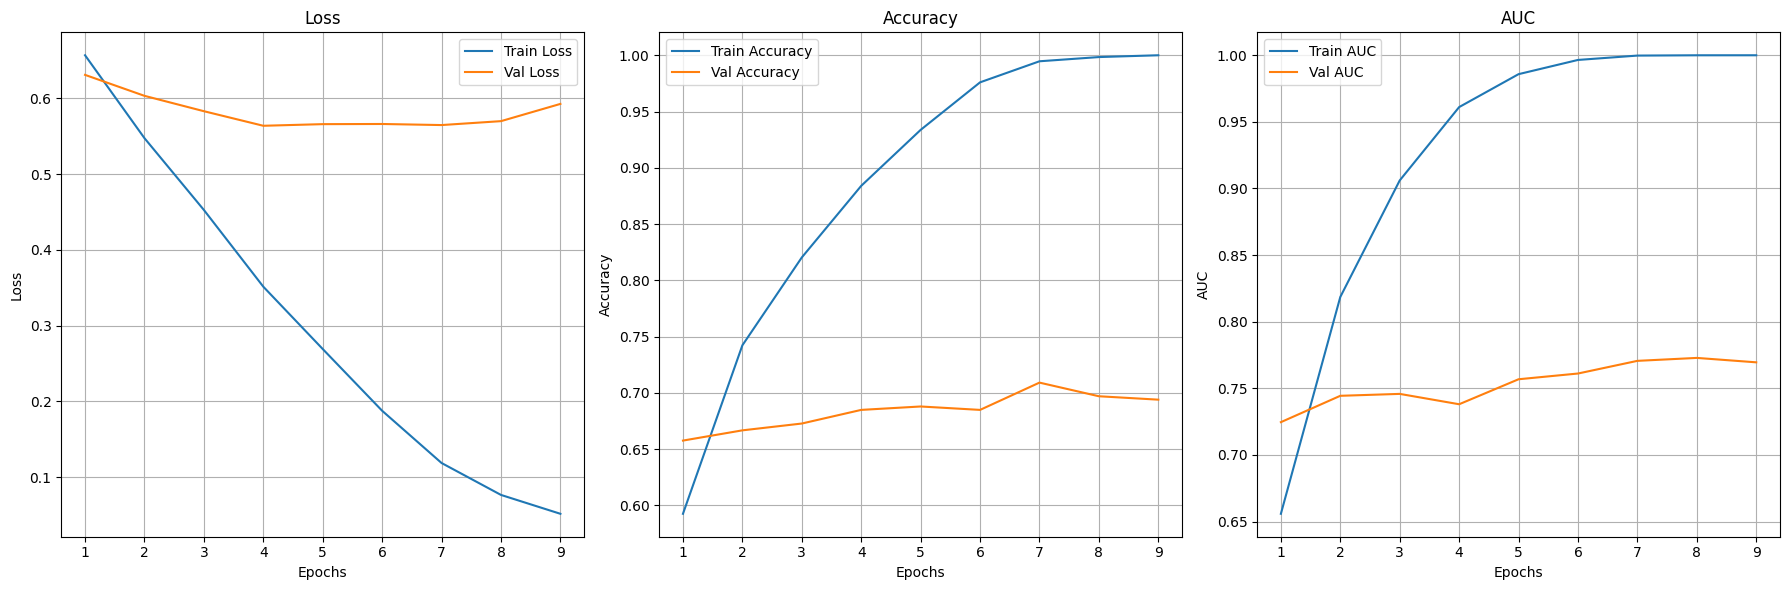

In [ ]:
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader

# Hyperparameter grid
parameters = {
    'epochs': [10], #, 20],
    'learning_rate': [0.0001], #, 0.001],
    'optimizer': [torch.optim.Adam], #, torch.optim.SGD],
    'batch_size': [64]
    # 'momentum': [0.5, 0.7, 0.9]
}

# Create parameter combinations
param_grid = ParameterGrid(parameters)

transform = transforms.Compose([
            transforms.Resize((105,105)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

# Datasets
train_dataset = SiameseDataset(train_pairs, transform)
val_dataset = SiameseDataset(val_pairs, transform)
test_dataset = SiameseDataset(test_pairs, transform)

best_config = None
best_config_score = 0
results = []

for params in param_grid:
    # Start timing
    start_time = time.time()

    print(f"Training with parameters: {params}")

    # Set the seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # DataLoaders for current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True,
                              worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id),
                              generator=torch.Generator().manual_seed(seed))
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    model = SiameseNetwork().cuda()
    model.initialize_weights()

    optimizer_cls = params['optimizer']
    learning_rate = params['learning_rate']
    epochs=params['epochs']
    momentum = params['momentum'] if optimizer_cls == torch.optim.SGD else 0  # Default to 0 for non-SGD optimizers


    history = model.train_model(
        train_loader, val_loader,
        epochs=epochs,
        learning_rate=learning_rate,
        optimizer_cls=optimizer_cls,
        momentum=momentum
    )

    end_time = time.time()
    runtime = end_time - start_time

    print(f"Runtime: {runtime:.2f} seconds")

    plot_history(history)

    print("Evaluating on Test Set:")
    test_loss, test_accuracy, test_auc = model.evaluate(test_loader)

    score = test_auc * 0.3 + test_accuracy * 0.4 - test_loss * 0.3

    print(f'Current configuration score is: {score}\n')
    if best_config_score < score:
        best_config_score = score
        best_config = params

    # Store results for comparison
    results.append({'params': params, 'test_loss': test_loss, 'test_auc': test_auc, 'test_accuracy': test_accuracy})


print(f"Best Configuration: {best_config}")
print(results)

## Qualitative Evaluation and Error Analysis

Training with parameters: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 1/10 | Train Loss: 0.6566 | Val Loss: 0.6307 | Train Acc: 0.5925 | Val Acc: 0.6576 | Train AUC: 0.6558 | Val AUC: 0.7246
Epoch 2/10 | Train Loss: 0.5473 | Val Loss: 0.6031 | Train Acc: 0.7422 | Val Acc: 0.6667 | Train AUC: 0.8186 | Val AUC: 0.7444
Epoch 3/10 | Train Loss: 0.4526 | Val Loss: 0.5828 | Train Acc: 0.8203 | Val Acc: 0.6727 | Train AUC: 0.9060 | Val AUC: 0.7458
Epoch 4/10 | Train Loss: 0.3514 | Val Loss: 0.5636 | Train Acc: 0.8840 | Val Acc: 0.6848 | Train AUC: 0.9611 | Val AUC: 0.7381
Epoch 5/10 | Train Loss: 0.2692 | Val Loss: 0.5658 | Train Acc: 0.9337 | Val Acc: 0.6879 | Train AUC: 0.9858 | Val AUC: 0.7568
Epoch 6/10 | Train Loss: 0.1877 | Val Loss: 0.5660 | Train Acc: 0.9759 | Val Acc: 0.6848 | Train AUC: 0.9965 | Val AUC: 0.7611
Epoch 7/10 | Train Loss: 0.1188 | Val Loss: 0.5645 | Train Acc: 0.9947 | Val Acc: 0.7091 | Train AUC: 0.9998

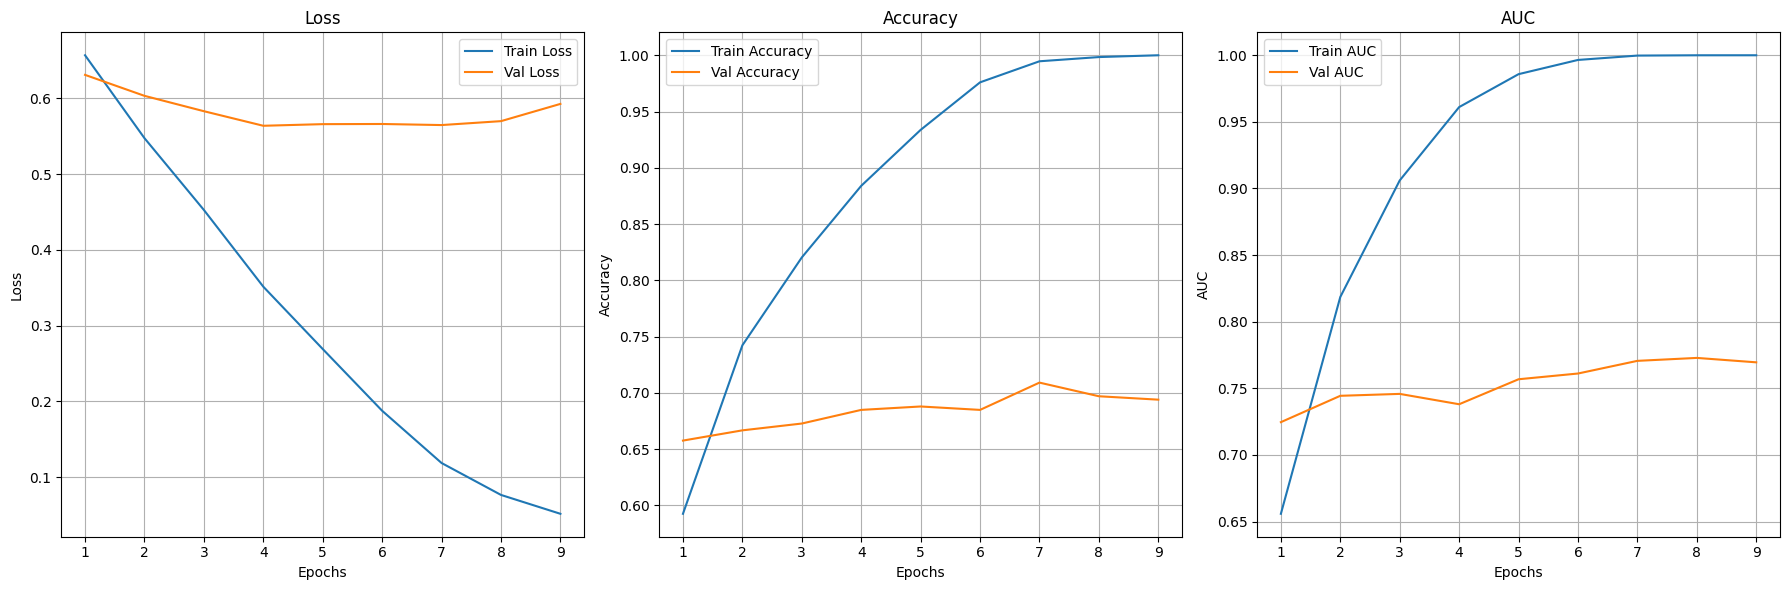

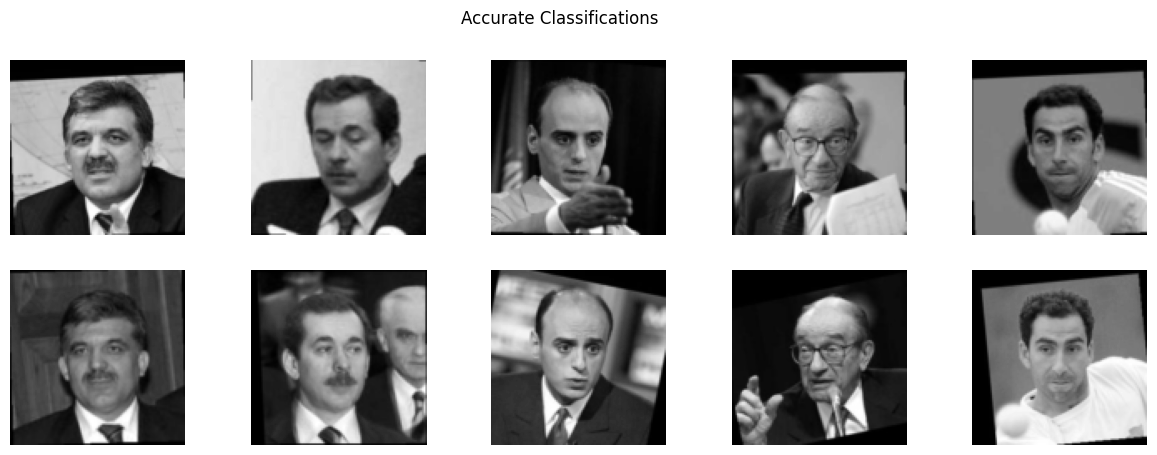

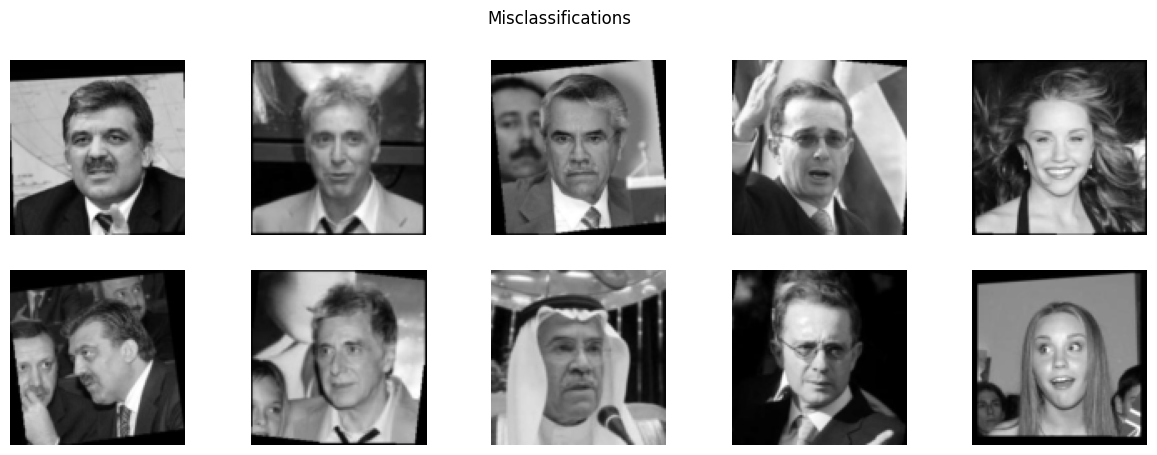

Current configuration score is: 0.3206420039666414

Best Configuration: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': <class 'torch.optim.adam.Adam'>}
[{'params': {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0001, 'optimizer': <class 'torch.optim.adam.Adam'>}, 'test_loss': 0.6384706534445286, 'test_auc': 0.769944, 'test_accuracy': 0.703}]


In [ ]:
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameter configuration
parameters = {
    'epochs': [10],
    'learning_rate': [0.0001],
    'optimizer': [torch.optim.Adam],
    'batch_size': [64]
}

# Create parameter combinations
param_grid = ParameterGrid(parameters)

transform = transforms.Compose([
            transforms.Resize((105,105)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

# Datasets
train_dataset = SiameseDataset(train_pairs, transform)
val_dataset = SiameseDataset(val_pairs, transform)
test_dataset = SiameseDataset(test_pairs, transform)

best_config = None
best_config_score = 0
results = []

for params in param_grid:
    # Start timing
    start_time = time.time()

    print(f"Training with parameters: {params}")

    # Set the seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # DataLoaders for current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True,
                              worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id),
                              generator=torch.Generator().manual_seed(seed))
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    model = SiameseNetwork().cuda()
    model.initialize_weights()

    optimizer_cls = params['optimizer']
    learning_rate = params['learning_rate']
    epochs = params['epochs']

    # Train the model
    history = model.train_model(
        train_loader, val_loader,
        epochs=epochs,
        learning_rate=learning_rate,
        optimizer_cls=optimizer_cls
    )

    end_time = time.time()
    runtime = end_time - start_time

    print(f"Runtime: {runtime:.2f} seconds")

    plot_history(history)

    print("Evaluating on Test Set:")
    test_loss, test_accuracy, test_auc = model.evaluate(test_loader)

    # Save predictions and true labels
    predictions, true_labels, image_pairs = [], [], []
    model.eval()
    with torch.no_grad():
        for (img1, img2), labels in test_loader:
            img1, img2, labels = img1.cuda(), img2.cuda(), labels.cuda()
            outputs = model(img1, img2).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            image_pairs.extend(zip(img1.cpu(), img2.cpu()))  # Save image pairs

    # Convert predictions to binary
    predicted_labels = (np.array(predictions) > 0.5).astype(int)

    # Find accurate and misclassified examples
    accurate_indices = np.where(predicted_labels == np.array(true_labels))[0]
    misclassified_indices = np.where(predicted_labels != np.array(true_labels))[0]

    print(f"Accurate classifications: {len(accurate_indices)}")
    print(f"Misclassifications: {len(misclassified_indices)}")

    # Display examples
    def plot_examples(indices, title, num_examples=5):
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(indices[:num_examples]):
            img1, img2 = image_pairs[idx]
            plt.subplot(2, num_examples, i + 1)
            plt.imshow(np.transpose(img1.numpy(), (1, 2, 0)), cmap='gray')
            plt.axis('off')

            plt.subplot(2, num_examples, i + 1 + num_examples)
            plt.imshow(np.transpose(img2.numpy(), (1, 2, 0)), cmap='gray')
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

    # Plot examples
    plot_examples(accurate_indices, "Accurate Classifications")
    plot_examples(misclassified_indices, "Misclassifications")

    # Scoring
    score = test_auc * 0.3 + test_accuracy * 0.4 - test_loss * 0.3
    print(f'Current configuration score is: {score}\n')

    if best_config_score < score:
        best_config_score = score
        best_config = params

    # Store results for comparison
    results.append({'params': params, 'test_loss': test_loss, 'test_auc': test_auc, 'test_accuracy': test_accuracy})

print(f"Best Configuration: {best_config}")
print(results)
